# Исходные данные

In [25]:
from scipy.integrate import odeint
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from numpy import pi, sin
import warnings as w

w.filterwarnings("ignore")

# Давления в каналах
p1 = 400e3
p2_0 = 300e3
p3 = 100e3

# Параметры демпфирующей жидкости
Vд_0 = 0
mд_0 = 0

# Параметры жидкости -> керосин
c = 1330
Vж0 = 0.004
ρж = 820

# Параметры газа -> гелий
k = 1.4
R = 297
Tгаз_0 = 293
Vгаз_0 = 0.003

# Коэффициенты инерционности
j1 = j2 = j3 = 400
jд = 20

# Коэффициенты сопротивления
ξ1 = ξ2 = ξ3 = 1000
ξд = 1000

A = 1000  # Амплитуда возмущения
T = 0.1  # Период возмущения

# Временной отрезок моделирования
t_end = .8
h = 1e-6
t = np.arange(0, t_end, h)


# Функции возмущения
def p2(t):
    """ Функция импульсного возмущения """
    if t <= T:
        z = 2 * t * pi/T
        insin = z - pi/2
        p2 = p2_0 + A*sin(insin) + A
    else:
        p2 = p2_0
    return p2


def p2_sin(t):
    """ Функция возмущения, изменяющаяся по синусу """
    z = 2 * t * pi/T
    insin = z - pi/2
    p2 = p2_0 + A*sin(insin)
    return p2


def p2_sin_afc(t, freq):
    """ Функция возмущения, зависящая от частоты """
    insin = freq * 2*pi * t 
    p2 = p2_0 + A*sin(insin)
    return p2

# Решение стационарной задачи

In [26]:
def system_static(vars):
    """ Система уравнений стационарной системы """
    m1_0, m2_0, m3_0, p4_0, pgas_0 = vars
    
    return [m1_0 + m2_0 - m3_0,
            p4_0 - pgas_0,
            p1 - p4_0 - ξ1*m1_0**2,
            p4_0 - p3 - ξ3*m3_0**2,
            p2_0 - p4_0 - ξ2*m2_0**2]


# Вводим начальные приближения
initial_guess = [5, 5, 5, 3e5, 3e5]

# Решение системы
sol_static = fsolve(system_static, initial_guess)

m1_0 = sol_static[0]
m2_0 = sol_static[1]
m3_0 = sol_static[2]
p4_0 = sol_static[3]
pgas_0 = sol_static[4]

rho_газ = pgas_0 / (R * Tгаз_0)
m_газ = rho_газ * Vгаз_0

# Вывод переменных
print("  m1_0 = {:.3f}".format(m1_0))
print("  m2_0 = {:.3f}".format(m2_0))
print("  m3_0 = {:.3f}".format(m3_0))
print("  p4_0 = {:.3f}".format(p4_0))
print("pgas_0 = {:.3f}".format(pgas_0))
print("  m_газ = {:.3f}".format(m_газ))

  m1_0 = 10.515
  m2_0 = 3.249
  m3_0 = 13.764
  p4_0 = 289442.719
pgas_0 = 289442.719
  m_газ = 0.010


# Решение динамической задачи с демпфером

## Решение СДУ

In [27]:
def system(y, t):
    """ Система дифференциальных уравнений """
    p4, Vд, m1, m2, m3, mд = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2(t) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    d_mд = (p4 - (m_газ / (Vгаз_0 - Vд)) * R * 
            (Tгаз_0 * ((p4 / p4_0)**((k-1)/k))) - 
                ξд * mд * abs(mд)) / jд
    
    return [d_p4, d_Vд, d_m1, d_m2, d_m3, d_mд]


y0 = [p4_0, Vд_0, m1_0, m2_0, m3_0, mд_0]

# Решение
sol = odeint(system, y0, t)

p_газ = (m_газ / (Vгаз_0 - sol[:, 1])) * R * \
    (Tгаз_0 * ((sol[:, 0] / p4_0)**((k-1)/k)))

In [28]:
max(sol[:, 0])

290167.63036016666

## Построение графиков

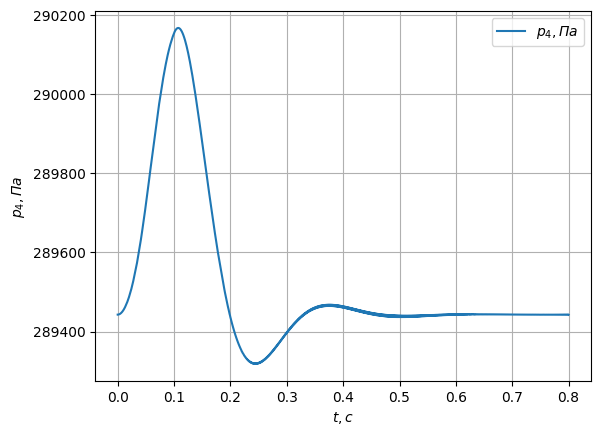

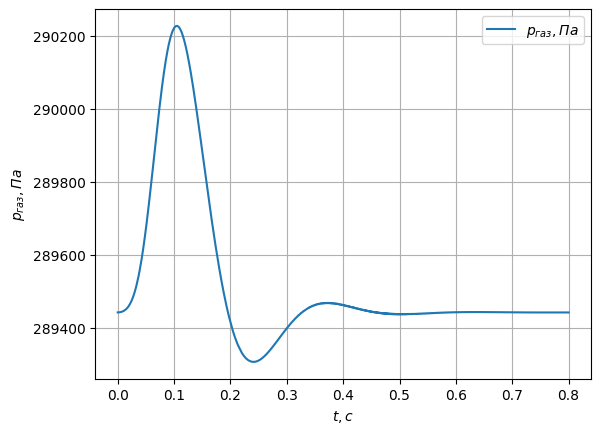

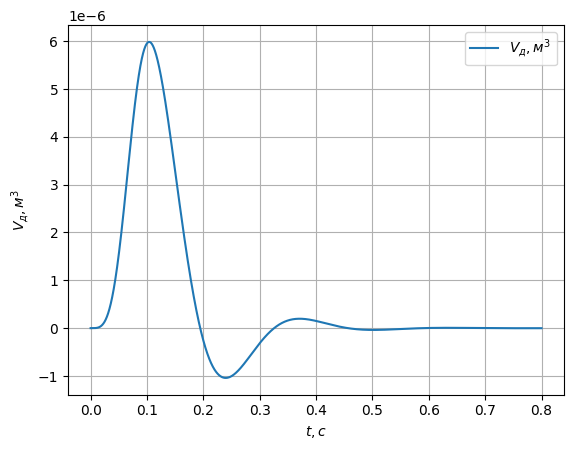

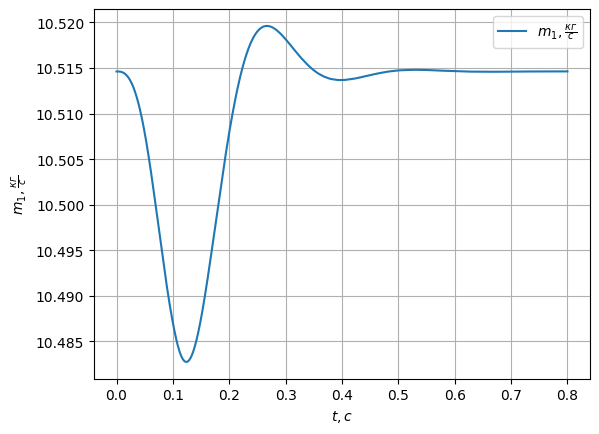

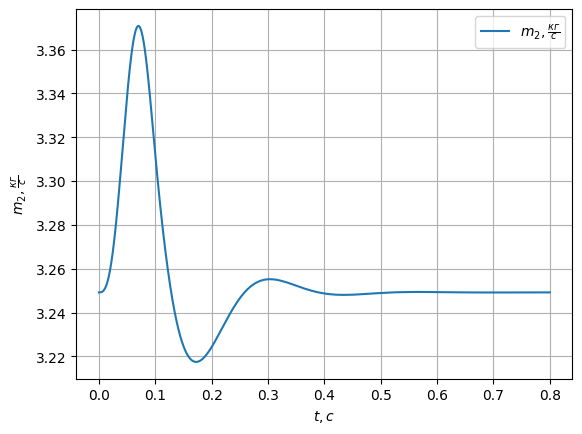

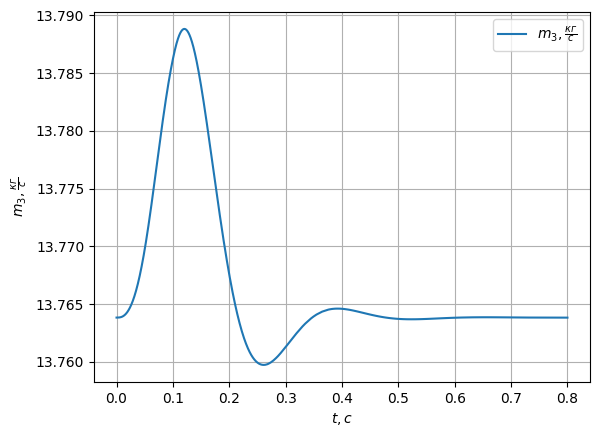

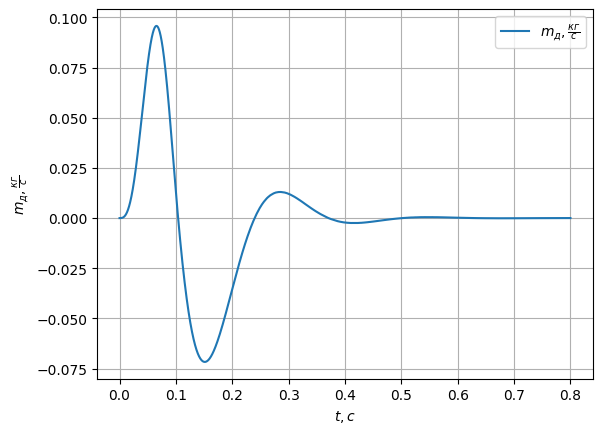

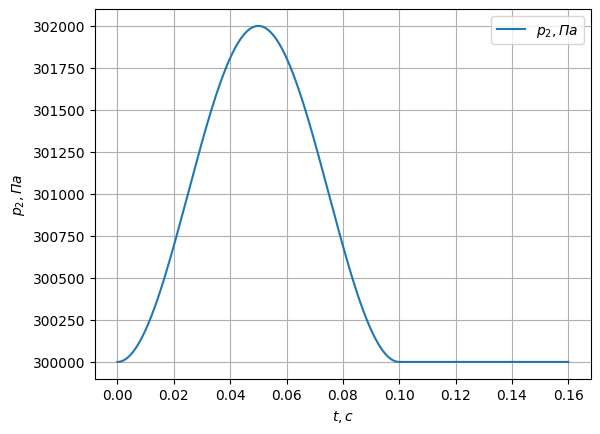

In [36]:
def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("$t, с$")
    plt.ylabel(label)
    plt.legend()
    plt.show()


plot(t, sol[:, 0], r"$p_4, Па$")
plot(t, p_газ, r"$p_{газ}, Па$")
plot(t, sol[:, 1], r"$V_д, м^3$")
plot(t, sol[:, 2], r"$m_1, \frac{кг}{с}$")
plot(t, sol[:, 3], r"$m_2, \frac{кг}{с}$")
plot(t, sol[:, 4], r"$m_3, \frac{кг}{с}$")
plot(t, sol[:, 5], r"$m_д, \frac{кг}{с}$")
plot(t[:int(t_end//h//5)], [p2(t) for t in t][:int(t_end//h//5)], "$p_2, Па$")

# Построение АЧХ системы с демпфером

## Решение

In [ ]:
def system_afc(y, t, freq):
    """ Система дифференциальных уравнений, зависящая от частоты """
    p4, Vд, m1, m2, m3, mд = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2_sin_afc(t, freq) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    d_mд = (p4 - (m_газ / (Vгаз_0 - Vд)) * R * 
            (Tгаз_0 * ((p4 / p4_0)**((k-1)/k))) - 
                ξд * mд * abs(mд)) / jд
    
    return [d_p4, d_Vд, d_m1, d_m2, d_m3, d_mд]


frequancy = []
for freq in np.arange(0, 16, 1):
    frequancy.append(freq)
for freq in np.arange(20, 105, 5):
    frequancy.append(freq)
for freq in np.arange(125, 1025, 25):
    frequancy.append(freq)

sol_afc = []
for i, freq in enumerate(frequancy):
    sol_afc.append(odeint(system_afc, y0, t, (freq,)))

amplitude = []
for freq in range(len(frequancy)):
    amplitude.append(
        (max(sol_afc[freq][700000:800000, 0]) - 
         min(sol_afc[freq][700000:800000, 0])) / 2 / A) 
        
print(amplitude)

## График АЧХ

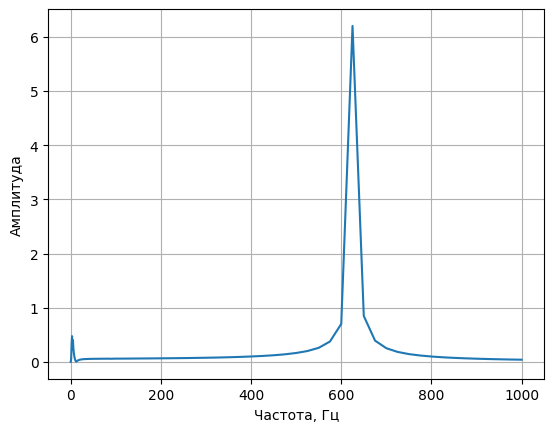

In [ ]:
plt.plot(frequancy, amplitude)
plt.grid()
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда")
plt.show()

# Решение динамической задачи без демпфера

## Решение СДУ

In [ ]:
def system_no_damper(y, t):
    """ Система дифференциальных уравнений """
    p4, m1, m2, m3 = y
    
    d_p4 = (m1 + m2 - m3) / ((Vж0) / c**2)
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2(t) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    
    return [d_p4, d_m1, d_m2, d_m3]


def p2(t):
    """ Функция возмущения """
    if t <= T:
        z = 2 * t * pi/T
        insin = z - pi/2
        p2 = p2_0 + A*sin(insin) + A
    else:
        p2 = p2_0
    return p2


t_end = .8
h = 1e-6
t = np.arange(0, t_end, h)

y0_n_d = [p4_0, m1_0, m2_0, m3_0]

sol_no_damper = odeint(system_no_damper, y0_n_d, t)

In [ ]:
max(sol_no_damper[:, 0])

290457.69395877153

## Построение графиков

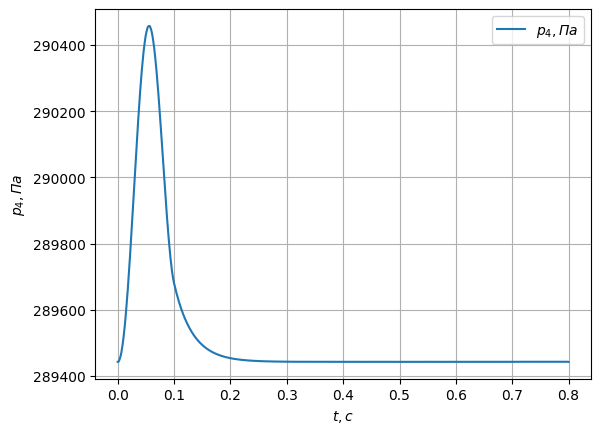

In [ ]:
plot(t, sol_no_damper[:, 0], r"$p_4, Па$")
# plot(t, sol_no_damper[:, 1], r"$m_1, \frac{кг}{с}$")
# plot(t, sol_no_damper[:, 2], r"$m_2, \frac{кг}{с}$")
# plot(t, sol_no_damper[:, 3], r"$m_3, \frac{кг}{с}$")

# Построение АЧХ системы без демпфера

## Решение

In [ ]:
def system_afc(y, t, freq):
    """ Система дифференциальных уравнений """
    p4, Vд, m1, m2, m3, mд = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2_sin_afc(t, freq) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    d_mд = (p4 - (m_газ / (Vгаз_0 - Vд)) * R * 
            (Tгаз_0 * ((p4 / p4_0)**((k-1)/k))) - 
                ξд * mд * abs(mд)) / jд
    
    return [d_p4, d_Vд, d_m1, d_m2, d_m3, d_mд]


frequancy = []
for freq in np.arange(0, 16, 1):
    frequancy.append(freq)
for freq in np.arange(20, 105, 5):
    frequancy.append(freq)
for freq in np.arange(125, 1025, 25):
    frequancy.append(freq)

sol_afc = []
for i, freq in enumerate(frequancy):
    sol_afc.append(odeint(system_afc, y0, t, (freq,)))

amplitude = []
for freq in range(len(frequancy)):
    amplitude.append(
        (max(sol_afc[freq][700000:800000, 0]) - 
         min(sol_afc[freq][700000:800000, 0])) / 2 / A) 
        
print(amplitude)

## График АЧХ

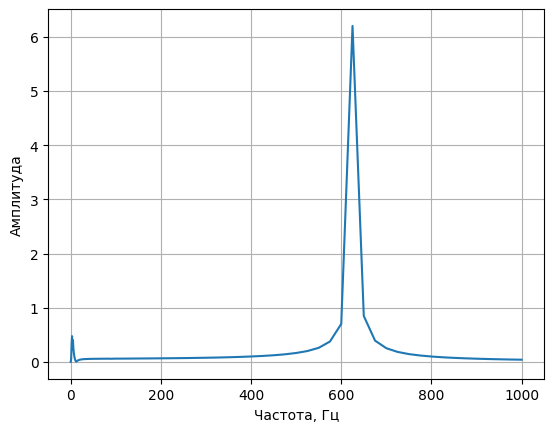

In [ ]:
plt.plot(frequancy, amplitude)
plt.grid()
plt.xlabel("Частота, Гц")
plt.ylabel("Амплитуда")
plt.show()